<a href="https://colab.research.google.com/github/PristovaAS/Innopolis/blob/main/ML/%D0%A0%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87_%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B8_%D0%B5%D1%81%D1%82%D0%B5%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D1%8F%D0%B7%D1%8B%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Работа с TF-IDF

In [32]:
!pip install wordcloud -q

!pip install natasha -q

!pip install pymorphy2 -q

In [12]:
import os # библиотеки работы с папками и системой

# и другие уже известные нам библиотеки
import pandas as pd
import numpy as np

import re # регулярные выражения: предобработка текстов, строить признаки-шаблоны на слова и подстроки текста и многое другое
import string # работа со строками (в тч пунктуация)

# импортируем основную библиотеку для работы с текстом
import nltk # пакет для символьной и статистической обработки естественного языка
from nltk.tokenize import word_tokenize, sent_tokenize #токенизация текста (слов, предложений)
from nltk.corpus import stopwords # набор стоп-слов из библиотеки

# Корпус UnigramTagger - теггер, который выбирает для каждого слова ту часть речи,
# с которой оно чаще всего встречалось в обучающем корпусе.
from nltk.tag import UnigramTagger

from nltk.stem import PorterStemmer # Метод, который принимает слово в качестве входного аргумента и возвращает слово, уменьшается до его корневой формы
from nltk.stem import WordNetLemmatizer # проставить соответствующий POS-тег для каждого слова при обработке текстов

import pymorphy2 # Для русского языка

# объект для лемматизации MorphVocab
# извлечение эмбеддингов из текста NewsEmbedding
# объект для синтаксического анализа NewsSyntaxParser
# извлечение имен собственных из текста NamesExtractor
# извлечение тэгов по морфологии NewsMorphTagger
# Segmenter
# создание объекта документа (можно создать из предложения, потом с ним работать и парсить, анализировать) Doc
from natasha import MorphVocab, NewsEmbedding, NewsSyntaxParser, NamesExtractor, NewsMorphTagger, Doc, Segmenter, NewsNERTagger

import wordcloud # отображение на графике мешка слов

from wordcloud import WordCloud

import matplotlib
import matplotlib.pyplot as plt # визуализация данных

from sklearn.feature_extraction.text import CountVectorizer # модель мешок слов
from sklearn.feature_extraction.text import TfidfVectorizer # модель TF IDF
from sklearn.feature_extraction.text import TfidfTransformer # модель TF IDF

import re

In [13]:
# загрузим модули nltk
#Удаление знаков препинания
nltk.download('punkt')

# Удаление стоп-слов
nltk.download('stopwords')

# Лексическая БД английского языка
nltk.download('wordnet')

# Разметчик использует алгоритм персептрона, чтобы определить, какой POS-тег присвоить тому или иному слову
nltk.download('averaged_perceptron_tagger')

# Загрузить список доступных тэгов для POS обработки
nltk.download('tagsets')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


True

In [14]:
plt.rcParams["figure.figsize"] = (10,5) # размер графиков

In [15]:
COMMON_DIR = "/content/drive/MyDrive/Innopolis/Songs/"

def read_text(filename):
    #Функция чтения файла
    text = ''
    with open(f'{COMMON_DIR}/{filename}.txt', 'r', encoding='utf-8') as f:
        text = f.read()
        text = text.replace('\n', ' ')
    return text

In [16]:
texts = []

direct_list = os.listdir(COMMON_DIR) # файлы в папке
print(direct_list)

names = [some_text.replace(".txt", "") for some_text in direct_list]
print(names)

['Белая луна.txt', 'Будем отдыхать.txt', 'Все За Одного (Добро).txt', 'Делай громче.txt', 'Давай повторим.txt', 'Мне глаза ее нравятся.txt', 'Думать о тебе (Добро).txt', 'Между нами ток.txt', 'Мне Не Снишься Ты.txt', 'Мой Путь.txt', 'Мой Путь (Добро).txt', 'На крыше.txt', 'На часах ноль-ноль.txt', 'Она не такая.txt', 'Почему так происходит.txt', 'Поцелуй (Добро, Поцелуй твой французский).txt', 'Только ты.txt', 'Тебе лучше меня не знать.txt', 'Ты меня ждешь.txt', 'Услышит весь район.txt', 'Что же ты молчишь.txt', 'Юность (Добро, Звук поставим на всю соседи не спят).txt', 'Я тебя лю.txt', 'Юность.txt', 'Я по частицам.txt', 'Я один из тех.txt']
['Белая луна', 'Будем отдыхать', 'Все За Одного (Добро)', 'Делай громче', 'Давай повторим', 'Мне глаза ее нравятся', 'Думать о тебе (Добро)', 'Между нами ток', 'Мне Не Снишься Ты', 'Мой Путь', 'Мой Путь (Добро)', 'На крыше', 'На часах ноль-ноль', 'Она не такая', 'Почему так происходит', 'Поцелуй (Добро, Поцелуй твой французский)', 

In [17]:
some_text_list = []
for some_text in names[:10]:
    some_text_list.append(read_text(some_text)) #чтение данных

len(some_text_list)

10

In [18]:
all_txt = []
txt = ''
for i in some_text_list:
  sent = re.sub(r'[.,"\'-?:!;...—«»…]', ' ', i)
  sent = sent.lower().replace('dabro', '')
  txt = txt + sent
all_txt.append(txt)
print(all_txt)

['давай все забудем  мы ведь взрослые люди мы сами все знаем  здесь нет виноватых здесь только два сердца  что любили когда то  оу  а я же видел это по другому оу  а мы же были так давно знакомы оу  и почему же так полна печали  ай яй яй  давай все начнем сначала  только белая луна вновь бросает свет у твоего окна я вижу силуэт ну где же ты была  понятно все без слов не смотришь на меня ты  смотришь на него  и только белая луна вновь бросает свет у твоего окна я вижу силуэт ну где же ты была  понятно все без слов не смотришь на меня ты  смотришь на него не смотришь на меня ты  смотришь на него не смотришь на меня ты  смотришь на него  тени сплетаются в одну  не во сне  а наяву тебя вижу и тону  слышишь  я тебя зову   ау  волки воют на луну   ау  выход есть и я найду  повторю  на всякий случай  я не самый лучший ты влюбилась не в того  я не в ту нам не будет просто и пока не поздно я хочу забыть  но не могу  и только белая луна вновь бросает свет у твоего окна я вижу силуэт ну где же ты

In [19]:
sw = ['оу', 'айяйяй', 'ау', 'твоей', 'свои', 'тобой', 'мой', 'твой', 'мой', 'это']
s = stopwords.words("russian")
s.extend(sw)
len(s)

161

In [20]:
text = ' '.join([word for word in all_txt[0].split(' ') if word not in s])
print(text)

давай забудем  взрослые люди сами знаем  виноватых сердца  любили   видел другому  давно знакомы  почему полна печали  ай яй яй  давай начнем сначала  белая луна вновь бросает свет твоего окна вижу силуэт  понятно слов смотришь  смотришь  белая луна вновь бросает свет твоего окна вижу силуэт  понятно слов смотришь  смотришь смотришь  смотришь смотришь  смотришь  тени сплетаются одну  сне  наяву вижу тону  слышишь  зову    волки воют луну    выход найду  повторю  всякий случай  самый лучший влюбилась  ту нам просто пока поздно хочу забыть  могу  белая луна вновь бросает свет твоего окна вижу силуэт  понятно слов смотришь  смотришь  белая луна вновь бросает свет твоего окна вижу силуэт  понятно слов смотришь  смотришь смотришь  смотришь смотришь  смотришь время поменять всё вокруг  ответ вопрос    прожить жизнь   скажет близкий друг   всё пора менять  понял сразу  жизнь коротка  всё тратим время зря  окончанье дня солнце закате  поставлю статус    уезжаю  обнял    яркое солнце нам подмиг

In [21]:
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform([text])
tfidf_vectorizer.vocabulary_

{'давай': 92,
 'забудем': 129,
 'взрослые': 30,
 'люди': 206,
 'сами': 399,
 'знаем': 145,
 'виноватых': 36,
 'сердца': 415,
 'любили': 202,
 'видел': 32,
 'другому': 116,
 'давно': 93,
 'знакомы': 148,
 'почему': 358,
 'полна': 342,
 'печали': 321,
 'ай': 2,
 'яй': 533,
 'начнем': 257,
 'сначала': 439,
 'белая': 3,
 'луна': 195,
 'вновь': 41,
 'бросает': 12,
 'свет': 405,
 'твоего': 480,
 'окна': 294,
 'вижу': 35,
 'силуэт': 419,
 'понятно': 348,
 'слов': 431,
 'смотришь': 437,
 'тени': 487,
 'сплетаются': 455,
 'одну': 290,
 'сне': 440,
 'наяву': 260,
 'тону': 498,
 'слышишь': 435,
 'зову': 153,
 'волки': 44,
 'воют': 49,
 'луну': 196,
 'выход': 68,
 'найду': 250,
 'повторю': 329,
 'всякий': 59,
 'случай': 433,
 'самый': 402,
 'лучший': 199,
 'влюбилась': 39,
 'ту': 502,
 'нам': 252,
 'просто': 373,
 'пока': 339,
 'поздно': 336,
 'хочу': 521,
 'забыть': 132,
 'могу': 229,
 'время': 52,
 'поменять': 344,
 'всё': 60,
 'вокруг': 43,
 'ответ': 306,
 'вопрос': 47,
 'прожить': 368,
 'жизнь

In [22]:
morph = pymorphy2.MorphAnalyzer() # Создать экземпляр Морфологического анализатора для русского языка

In [23]:
text1 = ' '.join([morph.parse(word)[0].normal_form for word in text.split(' ')])
print(text1)

давать забыть  взрослый человек сам знать  виноватый сердце  любить   видеть другой  давно знакомый  почему полный печаль  ай яй яй  давать начать сначала  белый луна вновь бросать свет твой окно видеть силуэт  понятно слово смотреть  смотреть  белый луна вновь бросать свет твой окно видеть силуэт  понятно слово смотреть  смотреть смотреть  смотреть смотреть  смотреть  тень сплетаться один  сон  наяву видеть тон  слышать  звать    волк выть луна    выход найти  повторить  всякий случай  самый хороший влюбиться  тот мы просто пока поздно хотеть забыть  мочь  белый луна вновь бросать свет твой окно видеть силуэт  понятно слово смотреть  смотреть  белый луна вновь бросать свет твой окно видеть силуэт  понятно слово смотреть  смотреть смотреть  смотреть смотреть  смотреть время поменять всё вокруг  ответ вопрос    прожить жизнь   сказать близкий друг   всё пора менять  понять сразу  жизнь короткий  всё тратить время зря  окончание день солнце закат  поставить статус    уезжать  обнять    я

In [24]:
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform([text1])
tfidf_vectorizer.vocabulary_

{'давать': 70,
 'забыть': 97,
 'взрослый': 28,
 'человек': 411,
 'сам': 312,
 'знать': 112,
 'виноватый': 30,
 'сердце': 323,
 'любить': 151,
 'видеть': 29,
 'другой': 87,
 'давно': 71,
 'знакомый': 111,
 'почему': 271,
 'полный': 258,
 'печаль': 239,
 'ай': 2,
 'яй': 419,
 'начать': 188,
 'сначала': 341,
 'белый': 3,
 'луна': 150,
 'вновь': 35,
 'бросать': 11,
 'свет': 315,
 'твой': 376,
 'окно': 216,
 'силуэт': 325,
 'понятно': 263,
 'слово': 336,
 'смотреть': 339,
 'тень': 377,
 'сплетаться': 355,
 'один': 212,
 'сон': 350,
 'наяву': 190,
 'тон': 384,
 'слышать': 338,
 'звать': 106,
 'волк': 38,
 'выть': 55,
 'выход': 56,
 'найти': 184,
 'повторить': 247,
 'всякий': 47,
 'случай': 337,
 'самый': 313,
 'хороший': 405,
 'влюбиться': 34,
 'тот': 386,
 'мы': 177,
 'просто': 288,
 'пока': 255,
 'поздно': 253,
 'хотеть': 406,
 'мочь': 175,
 'время': 43,
 'поменять': 259,
 'всё': 48,
 'вокруг': 37,
 'ответ': 226,
 'вопрос': 41,
 'прожить': 281,
 'жизнь': 93,
 'сказать': 327,
 'близкий': 7,

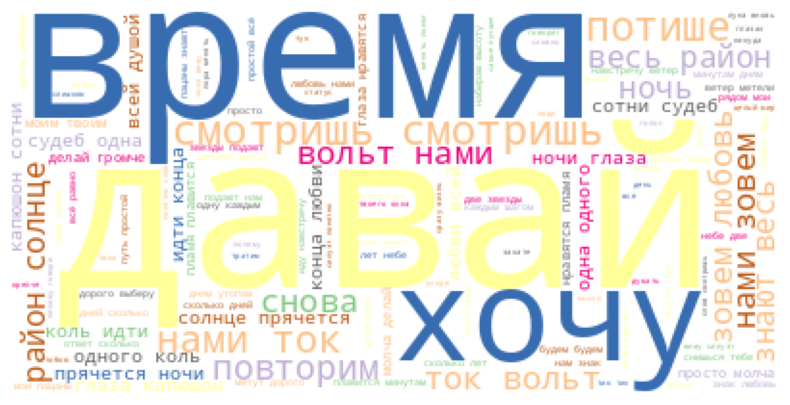

In [25]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.subplots_adjust(wspace=0.3, hspace=0.2)

i = 1

tokens = word_tokenize(text) # токены слов
text_raw = " ".join(tokens)
wordcloud = WordCloud(colormap='Accent', background_color='white', contour_width=10).generate(text_raw)
plt.tick_params(labelsize=10)
plt.imshow(wordcloud)
plt.axis("off")
plt.tick_params(labelsize=10)
i += 1

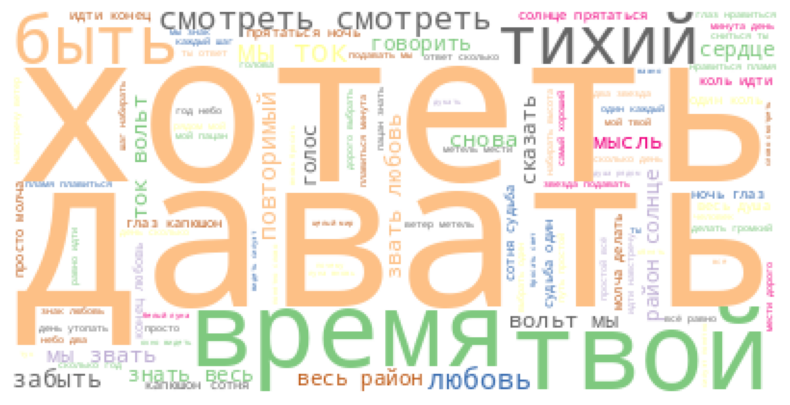

In [26]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.subplots_adjust(wspace=0.3, hspace=0.2)

i = 1

tokens = word_tokenize(text1) # токены слов
text_raw = " ".join(tokens)
wordcloud = WordCloud(colormap='Accent', background_color='white', contour_width=10).generate(text_raw)
plt.tick_params(labelsize=10)
plt.imshow(wordcloud)
plt.axis("off")
plt.tick_params(labelsize=10)
i += 1

**BERT**

In [1]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.6 MB/s eta 0:00:00


In [2]:
# импорт необходимых библиотек

import pandas as pd # табличное представление и чтение|запись csv
import numpy as np # векторы, матрицы
import random # случайный генератор
import time # измерение времени

# предобработка текста
import nltk
from nltk.corpus import stopwords # стоп-слова
from nltk.tokenize import word_tokenize # токенизация по словам

from sklearn.model_selection import train_test_split # разделение на тестовую и тренировочную выборки
import re # удаление знаков препинания через регулярное выражение

# нейронные слои
import torch
import torch.nn as nn # настройка нейросети (класс родитель)
import torch.optim as optim # оптимизация
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler # объекты настройки
import torch.nn.functional as F # функция softmax

# трансформеры, предобученные
from transformers import BertModel # класс модели BERT
from transformers import AdamW, get_linear_schedule_with_warmup # оптимизатор и загрузчик
from transformers import BertTokenizer, BertForSequenceClassification # Токенизатор, классификатор

from sklearn.metrics import accuracy_score, roc_curve, auc # метрики классификации

import matplotlib.pyplot as plt # график, визуализация

In [3]:
plt.rcParams["figure.figsize"] = (10,5) # размер графиков

plt.style.use('fivethirtyeight') # стиль графиков

In [4]:
nltk.download('stopwords') # стоп-слова
nltk.download('punkt') # пунктуация

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
df_BERT = pd.read_csv('/content/drive/MyDrive/Innopolis/IMDB Dataset.csv')

In [40]:
df_BERT

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [41]:
df_BERT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [42]:
df_BERT.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [43]:
df_BERT['review'] = df_BERT['review'].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))
df_BERT['sentiment'] = df_BERT['sentiment'].apply(lambda x: x.lower())

In [44]:
stop_words = stopwords.words('english')
stop_words.extend(['br']) # добавляет слово в словарь стоп-слов
stop_words = set(stop_words)
# по DataFrame в цикле столбец и внести изменения
df_BERT['review'] = df_BERT['review'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

In [45]:
df_BERT

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive
...,...,...
49995,thought movie right good job wasnt creative or...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary schools n...,negative
49998,im going disagree previous comment side maltin...,negative


In [16]:
df_BERT['review'] = df_BERT['review'].str.replace(' ', '_')
df_BERT

,review,sentiment
0,one_reviewers_mentioned_watching_1_oz_episode_...,positive
1,wonderful_little_production_filming_technique_...,positive
2,thought_wonderful_way_spend_time_hot_summer_we...,positive
3,basically_theres_family_little_boy_jake_thinks...,negative
4,petter_matteis_love_time_money_visually_stunni...,positive
...,...,...
49995,thought_movie_right_good_job_wasnt_creative_or...,positive
49996,bad_plot_bad_dialogue_bad_acting_idiotic_direc...,negative
49997,catholic_taught_parochial_elementary_schools_n...,negative
49998,im_going_disagree_previous_comment_side_maltin...,negative


In [46]:
print(df_BERT['sentiment'].unique())

['positive' 'negative']


In [47]:
df_BERT['sentiment'] = df_BERT['sentiment'].map({'negative': 0, 'positive': 1})
df_BERT

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically theres family little boy jake thinks...,0
4,petter matteis love time money visually stunni...,1
...,...,...
49995,thought movie right good job wasnt creative or...,1
49996,bad plot bad dialogue bad acting idiotic direc...,0
49997,catholic taught parochial elementary schools n...,0
49998,im going disagree previous comment side maltin...,0


In [90]:
x = df_BERT['review']
y = df_BERT['sentiment']

x_train, x_test, y_train, y_test = train_test_split (x, y, test_size=0.9, random_state=42)

In [91]:
print("Размеры тренировочной выборки:")
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")

print("Размеры тестовой выборки:")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")

Размеры тренировочной выборки:
x_train: (5000,), y_train: (5000,)
Размеры тестовой выборки:
x_test: (45000,), y_test: (45000,)


In [92]:
BERT_HUGGING_MODEL = 'bert-base-uncased'

In [93]:
tokenizer = BertTokenizer.from_pretrained(BERT_HUGGING_MODEL, do_lower_case=True)

In [94]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

In [95]:
init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


In [96]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased'] # максимальная max_length

print(max_input_length)

512


In [97]:
# cоздаем функцию для токенизации текста
def preprocessing_for_bert(data):

    # создаем пустые списки для хранения результатов
    input_ids = []
    attention_masks = []

    # для каждого предложения...
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            sent,                           # Предобработанный текст, исходные
            add_special_tokens=True,        # Добавление `[CLS]` и `[SEP]`
            max_length=MAX_LEN,             # Максимальная длина для усечения/дополнения
            pad_to_max_length=True,         # Дополнение предложения до максимальной длины
            return_attention_mask=True      # Возврат маски внимания
        )

        # добавляем результаты в соответствующие списки
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # преобразуем списки в тензоры
    input_ids = torch.tensor(input_ids) # обертка в тензор
    attention_masks = torch.tensor(attention_masks) # обертка в тензор

    return input_ids, attention_masks

In [98]:
print("Тренировочные данные (x_train):")
print(x_train)

print("\nТестовые данные (x_test):")
print(x_test)

Тренировочные данные (x_train):
5741     movie borderline crude humori utterly believe ...
33418    seen friends writing feel familiar especially ...
22423    sadly disappointed film due fact felt false ch...
11094    broad enough wait till see heavy handedbr adap...
18642    hitchcock opinion audiences arent really inter...
                               ...                        
11284    shadow magic recaptures joy amazement first mo...
44732    found movie quite enjoyable fairly entertainin...
38158    avoid one terrible movie exciting pointless mu...
860      production quite surprise absolutely love obsc...
15795    decent movie although little bit short time pa...
Name: review, Length: 5000, dtype: object

Тестовые данные (x_test):
33553    really liked summerslam due look arena curtain...
9427     many television shows appeal quite many differ...
199      film quickly gets major chase scene ever incre...
12447    jane austen would definitely approve onebr gwy...
39489    expec

In [99]:
# задаем максимальную длину последовательности
MAX_LEN = 128

# применим функцию 'preprocessing_for_bert' на тренировочном наборе данных и тестовом наборе данных
train_inputs, train_masks = preprocessing_for_bert(x_train)
test_inputs, test_masks = preprocessing_for_bert(x_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [100]:
print("train_masks:")
print(train_masks)

print("\ntrain_inputs:")
print(train_inputs)

train_masks:
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

train_inputs:
tensor([[  101,  3185,  3675,  ...,     0,     0,     0],
        [  101,  2464,  2814,  ...,  7117,  3494,   102],
        [  101, 13718,  9364,  ...,     0,     0,     0],
        ...,
        [  101,  4468,  2028,  ...,     0,     0,     0],
        [  101,  2537,  3243,  ...,     0,     0,     0],
        [  101, 11519,  3185,  ...,     0,     0,     0]])


In [101]:
# создаем DataLoader для тренировочных и тестовых данных

# преобразуем объект Series или DataFrame перекодировать в массивы NumPy
if isinstance(y_train, pd.Series):
    y_train=y_train.to_numpy()

if isinstance(y_test, pd.Series):
    y_test=y_test.to_numpy()

# создаем тензоры PyTorch для меток
train_labels = torch.LongTensor(y_train)
test_labels = torch.LongTensor(y_test)

# определим размер batch size (16 или 32)
batch_size = 32

# создание 'RandomSampler' и 'DataLoader'
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [102]:
# создаем классификатор на основе BERT
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()

        D_in, H, D_out = 768, 50, 2

        self.bert = BertModel.from_pretrained(BERT_HUGGING_MODEL)

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.3), LSTM, GRU
            nn.Linear(H, D_out)
        )

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # смотрим CLS - начало предложения (определяем отзыв)
        last_hidden_state_cls = outputs[0][:, 0, :]

        logits = self.classifier(last_hidden_state_cls)
        return logits

In [103]:
# инициализируем модель
EPOCH_NUM = 5

def initialize_model(epochs=EPOCH_NUM):
    # создаем экземпляр BertClassifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # задаем устройство (GPU T4)
    bert_classifier.to(device)

    # создаем оптимизатор
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,
                      eps=1e-8
                      )

    # делаем расчет циклов для работы
    total_steps = len(train_dataloader) * epochs

    # загрузчик, расписание (последовательность) и число циклов для обучения
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [104]:
# определим функцию обучения модели

# функция потерь (бинарная классификация), не бинарная - заменить функцию
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=1):

  random.seed(seed_value)
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, test_dataloader=None, epochs=EPOCH_NUM, evaluation=False):

    print("Начало тренировки...\n")
    for epoch_i in range(epochs):

        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Test Loss':^10} | {'Test Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # измерение времени (elapsed time of each epoch)
        t0_epoch, t0_batch = time.time(), time.time()

        # обнулить переменные
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # перевод в режим тренировки
        model.train()

        # для каждого batch
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # загружаем каждую batch в GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # использование нулевого градиента
            model.zero_grad()

            # добавляем в модель id и маски
            logits = model(b_input_ids, b_attn_mask)

            # считаем потери (Кросс Энтропия)
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # расчет градиентов функцией backward
            loss.backward()

            # решение проблемы "взрывных градиентов"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # обновляем шаг для оптимизатора и расписания
            optimizer.step()
            scheduler.step()

            # печатаем значения для каждых 20 batch
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # время расчета 20 batches
                time_elapsed = time.time() - t0_batch

                # результаты
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # обнулим переменные
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # средняя функция потерь
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)

        if evaluation == True:
            # считается точность
            test_loss, test_accuracy = evaluate(model, test_dataloader)

            # общее время, затраченное на измерение
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {test_loss:^10.6f} | {test_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Тренировка завершена!")

In [105]:
# определим функцию вычисления показателей качества модели (функцию потерь и точность)
def evaluate(model, test_dataloader):

    model.eval()

    test_accuracy = []
    test_loss = []

    for batch in test_dataloader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        loss = loss_fn(logits, b_labels)
        test_loss.append(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()

        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        test_accuracy.append(accuracy)

    test_loss = np.mean(test_loss)
    test_accuracy = np.mean(test_accuracy)

    return test_loss, test_accuracy

In [106]:
# определяем устройство для модели
device = torch.device("cuda")

In [107]:
# обучение модели
set_seed(1)
bert_classifier, optimizer, scheduler = initialize_model(epochs=3)
train(bert_classifier, train_dataloader, test_dataloader, epochs=3, evaluation=True)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Начало тренировки...

 Epoch  |  Batch  |  Train Loss  | Test Loss  | Test Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.684314   |     -      |     -     |   13.54  
   1    |   40    |   0.492140   |     -      |     -     |   13.09  
   1    |   60    |   0.443712   |     -      |     -     |   13.56  
   1    |   80    |   0.390645   |     -      |     -     |   13.96  
   1    |   100   |   0.415755   |     -      |     -     |   14.07  
   1    |   120   |   0.355883   |     -      |     -     |   13.71  
   1    |   140   |   0.393965   |     -      |     -     |   13.56  
   1    |   156   |   0.364569   |     -      |     -     |   10.31  
----------------------------------------------------------------------
   1    |    -    |   0.446151   |  0.319836  |   86.17   |  427.65  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Test Loss  | Test Acc  |  El

In [108]:
# загрузим натренированную модель
def bert_predict(model, test_dataloader):
    model.eval()

    all_logits = []

    for batch in test_dataloader:
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)

    # Сбор из каждого batch результатов в один объект
    all_logits = torch.cat(all_logits, dim=0)

    # Для вероятности принадлежности к классу
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [109]:
# построим график ROC-кривой для наглядной оценки качества предсказания
def evaluate_roc(probs, y_true):

    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # ROC AUC
    plt.title('Оценка ROC AUC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.9446
Accuracy: 86.99%


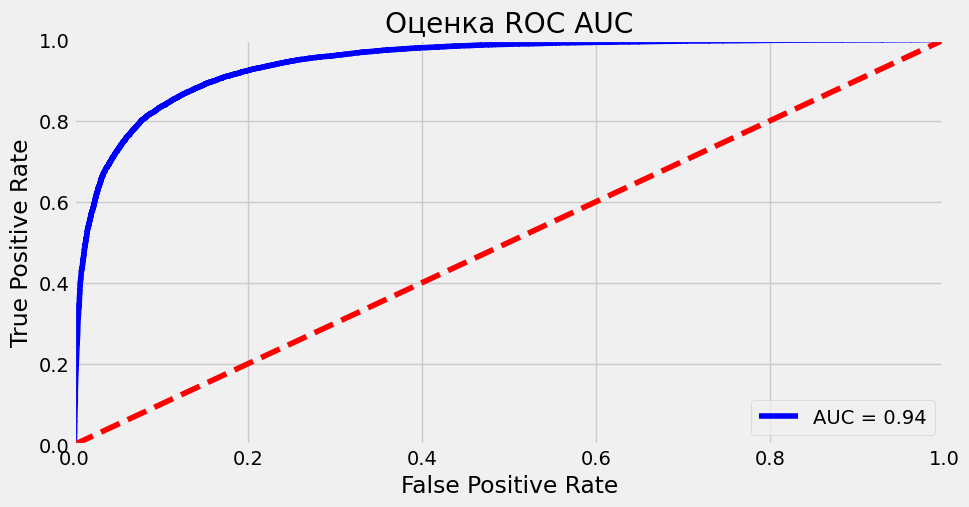

In [110]:
# вычислим предсказанные вероятности на тестовых данных
probs = bert_predict(bert_classifier, test_dataloader) # оценка занимает время

# оценим Bert classifier
evaluate_roc(probs, y_test)